# Exploration 15
## 트랜스포머 모델로 챗봇 만들기 🎯

### Table of contents
1. [데이터 수집]()
2. [데이터 전처리]()
3. [SubwordTextEncoder]()
4. [Transfomer components]()
	
    - Positional Encoding
	- Scaled_dot_product_attention
	- MultiHeadAttention
	- Masks
	- Encoder
	- Decoder
	- Transformer
    

5. [모델링]()
6. [개선을 위한 전처리 수정]()
7. [하이퍼파리미터 튜닝]()
8. [회고]()

## 1. 데이터 수집

In [449]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [450]:
data_dir = os.getenv("HOME") + '/aiffel/transformer_chatbot/data/ChatbotData .csv'
chatbotdata = pd.read_csv(data_dir)

In [451]:
chatbotdata.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [452]:
mid = len(chatbotdata) // 2
chatbotdata.iloc[mid:mid+5]

,Q,A,label
5911,너무 가슴이 아프네,무슨 마음인지 알겠어서 더 마음이 아프네요.,1
5912,너무 괴롭네.,무슨 마음인지 알겠어서 더 마음이 아프네요.,1
5913,너무 끔직한 5월의 연휴도,다 지나갈 거예요.,1
5914,너무 너무 억울하다.,억울함이 풀리길 바랄게요.,1
5915,너무 늦은 깨달음,너무 늦지 않았을 거예요.,1


In [453]:
chatbotdata.tail()

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


## 2. 데이터 전처리

구두점을 띄워주고 중복되는 공백을 하나의 공백으로 바꿔주는 최소한의 전처리를 진행해보자

In [454]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [455]:
def load_conversations():
    
    questions = chatbotdata['Q'].apply(preprocess_sentence)
    answers = chatbotdata['A'].apply(preprocess_sentence)
    
    return questions.to_numpy(), answers.to_numpy()

In [456]:
questions, answers = load_conversations()
print(f"전체 질문 샘플 수: {len(questions)}")
print(f"전체 답변 샘플 수: {len(answers)}")

전체 질문 샘플 수: 11823
전체 답변 샘플 수: 11823


In [457]:
rng = np.random.default_rng()


for _ in range(5):
    idx = rng.integers(len(answers))
    print(f'전처리 후의 {idx}번째 질문 샘플: {questions[idx]}')
    print(f'전처리 후의 {idx}번째 답변 샘플: {answers[idx]}')
    print('=' * 50)

전처리 후의 125번째 질문 샘플: 게임 같이 하자고 할까 ?
전처리 후의 125번째 답변 샘플: 안 될 것도 없죠 .
전처리 후의 11554번째 질문 샘플: 짝녀한테 의미 없는 선톡 해도 될까요 ?
전처리 후의 11554번째 답변 샘플: 선톡을 해야 대화도 이어나가니까요 .
전처리 후의 6152번째 질문 샘플: 또 다시 낮술
전처리 후의 6152번째 답변 샘플: 낮술 조금만 하세요 .
전처리 후의 1169번째 질문 샘플: 담배 끊는 거 어려워
전처리 후의 1169번째 답변 샘플: 자신을 이겨야해요 .
전처리 후의 7263번째 질문 샘플: 외로워서
전처리 후의 7263번째 답변 샘플: 많이 힘든가봅니다 .


## 3. SubwordTextEncoder 사용하기

In [458]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, 
                                                                      target_vocab_size=2**13)

In [459]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1]

In [460]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8369]
END_TOKEN의 번호 : [8370]


In [461]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정한다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8371


In [462]:
rng = np.random.default_rng()


for _ in range(5):
    idx = rng.integers(len(answers))
    print(f'전처리 후의 {idx}번째 질문 샘플: {tokenizer.encode(questions[idx])}')
    print(f'전처리 후의 {idx}번째 답변 샘플: {tokenizer.encode(answers[idx])}')
    print('=' * 50)

전처리 후의 10509번째 질문 샘플: [6758, 1105, 525, 116, 3395, 174, 2331, 2]
전처리 후의 10509번째 답변 샘플: [7364, 98, 7464, 2473, 1082, 93, 1]
전처리 후의 7348번째 질문 샘플: [79, 229, 179, 2087, 4987, 1361]
전처리 후의 7348번째 답변 샘플: [143, 294, 13, 2510, 1]
전처리 후의 4004번째 질문 샘플: [6409, 2745, 2]
전처리 후의 4004번째 답변 샘플: [311, 96, 783, 5, 30, 3, 1]
전처리 후의 7308번째 질문 샘플: [2536, 6619, 534, 214, 1]
전처리 후의 7308번째 답변 샘플: [485, 4810, 575, 4074, 27, 230, 137, 17, 21, 1]
전처리 후의 4557번째 질문 샘플: [4837, 8145, 20, 159]
전처리 후의 4557번째 답변 샘플: [768, 1938, 4836, 8145, 5, 30, 3, 1]


In [463]:
q_len = [len(s.split()) for s in questions]
a_len = [len(s.split()) for s in answers]

Text(0.5, 1.0, 'Answers')

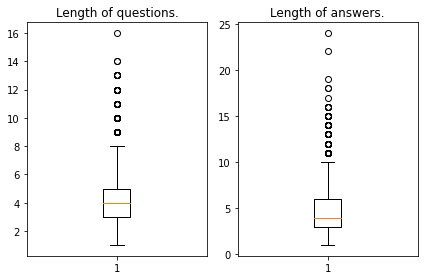

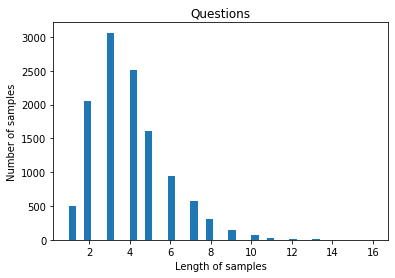

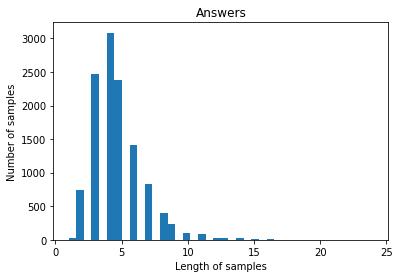

In [464]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axs = axes.ravel()

axs[0].boxplot(q_len)
axs[0].set_title("Length of questions.")

axs[1].boxplot(a_len)
axs[1].set_title("Length of answers.")

fig.tight_layout()

fig2, ax2 = plt.subplots()
ax2.hist(q_len, bins=40)
ax2.set_xlabel("Length of samples")
ax2.set_ylabel("Number of samples")
ax2.set_title("Questions")

fig3, ax3 = plt.subplots()
ax3.hist(a_len, bins=40)
ax3.set_xlabel("Length of samples")
ax3.set_ylabel("Number of samples")
ax3.set_title("Answers")

In [465]:
print(f"95% of q_len is :{np.percentile(q_len, 95)}")
print(f"95% of a_len is :{np.percentile(a_len, 95)}")

95% of q_len is :7.0
95% of a_len is :8.0


데이터셋의 크기가 크지 않으므로 최대길이를 예제와 같이 40으로 정해 모든 단어를 포함하는 방향으로 진행한다.

In [466]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt+1
            
    print(f"전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {cnt/len(nested_list):.2%}")

In [467]:
print("Questions\n>>>")
below_threshold_len(40, questions)
print("Answers\n>>>")
below_threshold_len(40, answers)

Questions
>>>
전체 샘플 중 길이가 40 이하인 샘플의 비율: 100.00%
Answers
>>>
전체 샘플 중 길이가 40 이하인 샘플의 비율: 100.00%


In [468]:
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [469]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [470]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8371
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [471]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

[BUFFER_SIZE in shuffle](https://helloyjam.github.io/tensorflow/buffer-size-in-shuffle/)

## 4. 모델링

### Postional Encoding

In [472]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
    
    

### Scaled_dot_product_attention

In [473]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b = True)
    
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    if mask is not None:
        logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    output = tf.matmul(attention_weights, value)
    return output

### MultiHeadAttention

In [474]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        
        outputs = self.dense(concat_attention)
        
        return outputs

### Masks

In [475]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]


In [476]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### Encoder

In [477]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs+attention)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)



In [478]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embedding = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)


### Decoder

In [479]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model))
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
    })
    
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)
    
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
    })
    
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [480]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### Transformer

In [481]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
    
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 5. 모델링

In [482]:
tf.keras.backend.clear_session()


NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3197184     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [483]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

In [484]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [485]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [486]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [487]:
EPOCHS = 50
callback = tf.keras.callbacks.EarlyStopping(monitor='loss')
model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[callback])

Epoch 1/50
185/185 [==============================] - 32s 141ms/step - loss: 1.5416 - accuracy: 0.0113
Epoch 2/50
185/185 [==============================] - 26s 138ms/step - loss: 1.2531 - accuracy: 0.0471
Epoch 3/50
185/185 [==============================] - 27s 147ms/step - loss: 1.0301 - accuracy: 0.0501
Epoch 4/50
185/185 [==============================] - 26s 142ms/step - loss: 0.9396 - accuracy: 0.0534
Epoch 5/50
185/185 [==============================] - 26s 143ms/step - loss: 0.8789 - accuracy: 0.0570
Epoch 6/50
185/185 [==============================] - 26s 142ms/step - loss: 0.8225 - accuracy: 0.0612
Epoch 7/50
185/185 [==============================] - 26s 142ms/step - loss: 0.7430 - accuracy: 0.0670
Epoch 8/50
185/185 [==============================] - 25s 137ms/step - loss: 0.6657 - accuracy: 0.0763
Epoch 9/50
185/185 [==============================] - 26s 139ms/step - loss: 0.5702 - accuracy: 0.0863
Epoch 10/50
185/185 [==============================] - 26s 140ms/step - l

In [504]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [505]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [506]:
sentence_generation('출근길 너무 힘들어')

입력 : 출근길 너무 힘들어
출력 : 회사 근처로 이사를 가보세요 .


'회사 근처로 이사를 가보세요 .'

In [507]:
sentence_generation('안녕, 넌 이름이 뭐니?')

입력 : 안녕, 넌 이름이 뭐니?
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'

In [508]:
sentence_generation('오늘 날씨는 어때?')

입력 : 오늘 날씨는 어때?
출력 : 친구들과 같이 놀러가세요 .


'친구들과 같이 놀러가세요 .'

In [510]:
sentence_generation('오늘 날씨는 어떠니?')

입력 : 오늘 날씨는 어떠니?
출력 : 저랑 이야기 해요 .


'저랑 이야기 해요 .'

In [511]:
sentence_generation('오늘 날씨는 어땡?')

입력 : 오늘 날씨는 어땡?
출력 : 정말 기분 좋으시겠어요 .


'정말 기분 좋으시겠어요 .'

In [513]:
sentence_generation('오늘 날씨는 어때??')

입력 : 오늘 날씨는 어때??
출력 : 저랑 같이 놀아요 .


'저랑 같이 놀아요 .'

In [515]:
sentence_generation('오늘 날씨는 어때ㅋㅋㅋㅋㅋ')

입력 : 오늘 날씨는 어때ㅋㅋㅋㅋㅋ
출력 : 이젠 기억을 놔주는 건 어떨까요 .


'이젠 기억을 놔주는 건 어떨까요 .'

In [517]:
sentence_generation('ㅋ')

입력 : ㅋ
출력 : 새로운 사람으로 잊혀질 거예요 .


'새로운 사람으로 잊혀질 거예요 .'

In [516]:
sentence_generation('ㅋㅋ')

입력 : ㅋㅋ
출력 : 좋은 사람이랑 결혼할 수 있을 거예요 .


'좋은 사람이랑 결혼할 수 있을 거예요 .'

In [518]:
sentence_generation('ㅋㅋㅋ')

입력 : ㅋㅋㅋ
출력 : 좋은 소식길 바라요 .


'좋은 소식길 바라요 .'

In [550]:
sentence_generation('날씨 좋아?')

입력 : 날씨 좋아?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

In [551]:
sentence_generation('날씨 좋아!')

입력 : 날씨 좋아!
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

정확도는 약 18%에서 Earlystopping을 했지만 문장자체는 비교적 자연스럽게 생성하는 것 같습니다. 하지만 같은 의미의 문장이여도 의미 자체를 다르게 받아들이고 부자연스러운 답변을 생성하는 경우도 많네요.

## 6. 개선을 위한 전처리 수정

### 1. 'ㅋㅋㅋ', 'ㅠㅠㅠ'와 같은 단어들을 'ㅋㅋ', 'ㅠㅠ' 로 바꿔주기.

In [640]:
questions = chatbotdata['Q'].to_numpy()
answers = chatbotdata['A'].to_numpy()

In [641]:
chatbotdata.loc[chatbotdata['Q'].str.contains('ㅠㅠㅠ')]

,Q,A,label
8758,혼자ㅠㅠㅠ,많이 힘들어하지 마요.,1


In [642]:
sentence = '혼자ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ'
sentence = re.sub("(.)\\1{1,}", r"\1\1", sentence)
print(sentence)

sentence = '혼자ㅠㅠ'
sentence = re.sub("(.)\\1{1,}", r"\1\1", sentence)
print(sentence)

sentence = '뭐야ㅋㅋㅋㅋㅋㅋㅋㅋㅋ'
sentence = re.sub("(.)\\1{1,}", r"\1\1", sentence)
print(sentence)

sentence = '뭐야ㅋㅋㅋㅋ'
sentence = re.sub("(.)\\1{1,}", r"\1\1", sentence)
print(sentence)

혼자ㅠㅠ
혼자ㅠㅠ
뭐야ㅋㅋ
뭐야ㅋㅋ


추가적으로 느낌표와 물음표 등은 "!!", "??"가 각각 "!", "?"와 같은 의미를 가진다고 생각할 수 있습니다.
(".." 와 "." 는 조금 의미가 다르다고 생각해 전처리 과정에 포함시키지 않았습니다.)

In [643]:
sentence = '뭐야????!!!!!!!!!'
sentence = re.sub("(!)\\1{1,}", r"\1", sentence)
sentence = re.sub("(\?)\\1{1,}", r"\1", sentence)
print(sentence)

뭐야?!


### 2. 특수문자 제거

In [644]:
sentence = '"저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요"'
sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)
sentence = re.sub(r'[" "]+', " ", sentence)
print(sentence)

 저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요 


위 두 전처리를 전처리 함수에 추가해보겠습니다.

In [645]:
sentence = '"저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요.ㅋㅋㅋㅋㅋ"'
sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
print(sentence)
sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
print(sentence)
sentence = re.sub(r'[" "]+', " ", sentence)
print(sentence)
sentence = re.sub("(.)\\1{1,}", r"\1\1", sentence)
print(sentence)
sentence = sentence.strip()
print(sentence)

"저를 만들어 준 사람을 부모님 ,  저랑 이야기해 주는 사람을 친구로 생각하고 있어요 . ㅋㅋㅋㅋㅋ"
 저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요 . ㅋㅋㅋㅋㅋ 
 저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요 . ㅋㅋㅋㅋㅋ 
 저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요 . ㅋㅋ 
저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요 . ㅋㅋ


In [646]:
sentence = '"이게 무슨일이야??!??!!!"'
sentence = re.sub("(!)\\1{1,}", r"\1", sentence)
print(sentence)
sentence = re.sub("(\?)\\1{1,}", r"\1", sentence)
print(sentence)
sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
print(sentence)
sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
print(sentence)
sentence = re.sub(r'[" "]+', " ", sentence)
print(sentence)
sentence = re.sub("(.)\\1{1,}", r"\1\1", sentence)
print(sentence)
sentence = sentence.strip()
print(sentence)

"이게 무슨일이야??!??!"
"이게 무슨일이야?!?!"
"이게 무슨일이야 ?  !  ?  ! "
 이게 무슨일이야 ? ! ? ! 
 이게 무슨일이야 ? ! ? ! 
 이게 무슨일이야 ? ! ? ! 
이게 무슨일이야 ? ! ? !


In [647]:
def preprocess_sentence(sentence):
    sentence = re.sub("(!)\\1{1,}", r"\1", sentence) ## 연속 느낌표 제거
    sentence = re.sub("(\?)\\1{1,}", r"\1", sentence) ## 연속 물음표 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) ## 구둣점 분리
    sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)
    sentence = re.sub("(.)\\1{1,}", r"\1\1", sentence) ## 반복되는 ㅋㅋㅋ => ㅋㅋ
    sentence = sentence.strip()
    
    return sentence

In [648]:
def load_conversations():
    
    questions = chatbotdata['Q'].apply(preprocess_sentence)
    answers = chatbotdata['A'].apply(preprocess_sentence)
    
    return questions.to_numpy(), answers.to_numpy()

In [649]:
questions, answers = load_conversations()
print(f"전체 질문 샘플 수: {len(questions)}")
print(f"전체 답변 샘플 수: {len(answers)}")

전체 질문 샘플 수: 11823
전체 답변 샘플 수: 11823


In [650]:
rng = np.random.default_rng()


for _ in range(5):
    idx = rng.integers(len(answers))
    print(f'전처리 후의 {idx}번째 질문 샘플: {questions[idx]}')
    print(f'전처리 후의 {idx}번째 답변 샘플: {answers[idx]}')
    print('=' * 50)

전처리 후의 1523번째 질문 샘플: 말 잘하는 법
전처리 후의 1523번째 답변 샘플: 책을 많이 읽어보세요 .
전처리 후의 11532번째 질문 샘플: 짝녀랑 연락이 끊겼는데 더 연락하고 싶어 .
전처리 후의 11532번째 답변 샘플: 연락할 핑계를 찾아보세요 .
전처리 후의 4328번째 질문 샘플: 진짜 별 사람이 다 있어
전처리 후의 4328번째 답변 샘플: 정말 특이한 사람 많죠 .
전처리 후의 2180번째 질문 샘플: 불안해
전처리 후의 2180번째 답변 샘플: 두려워하지 않아도 돼요 .
전처리 후의 9761번째 질문 샘플: 몰래 동거하고 있어
전처리 후의 9761번째 답변 샘플: 허락을 맡고 당당하게 하는 게 좋을 것 같아요 .


## SubwordTextEncoder 사용하기

In [651]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, 
                                                                      target_vocab_size=2**13)

In [652]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1]

In [653]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8348]
END_TOKEN의 번호 : [8349]


In [654]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8350


In [655]:
rng = np.random.default_rng()


for _ in range(5):
    idx = rng.integers(len(answers))
    print(f'전처리 후의 {idx}번째 질문 샘플: {tokenizer.encode(questions[idx])}')
    print(f'전처리 후의 {idx}번째 답변 샘플: {tokenizer.encode(answers[idx])}')
    print('=' * 50)

전처리 후의 5869번째 질문 샘플: [50, 3664, 977, 687, 1]
전처리 후의 5869번째 답변 샘플: [831, 22, 1420, 1]
전처리 후의 3583번째 질문 샘플: [4065, 1233, 428, 6148, 4871, 786]
전처리 후의 3583번째 답변 샘플: [1413, 13, 3954, 1]
전처리 후의 6944번째 질문 샘플: [58, 205, 43, 5775]
전처리 후의 6944번째 답변 샘플: [4488, 3439, 1]
전처리 후의 3600번째 질문 샘플: [765, 2305, 312, 9, 59]
전처리 후의 3600번째 답변 샘플: [466, 912, 131, 7436, 1]
전처리 후의 4754번째 질문 샘플: [1774, 3033]
전처리 후의 4754번째 답변 샘플: [678, 387, 1]


In [656]:
q_len = [len(s.split()) for s in questions]
a_len = [len(s.split()) for s in answers]

Text(0.5, 1.0, 'Answers')

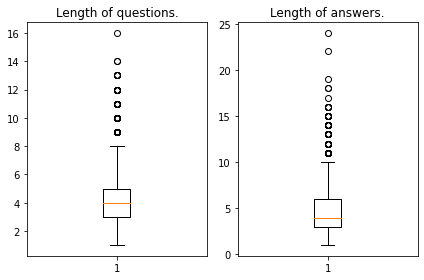

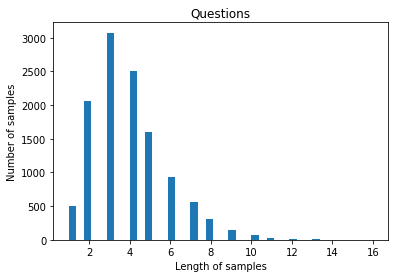

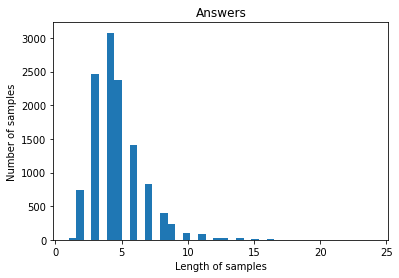

In [657]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axs = axes.ravel()

axs[0].boxplot(q_len)
axs[0].set_title("Length of questions.")

axs[1].boxplot(a_len)
axs[1].set_title("Length of answers.")

fig.tight_layout()

fig2, ax2 = plt.subplots()
ax2.hist(q_len, bins=40)
ax2.set_xlabel("Length of samples")
ax2.set_ylabel("Number of samples")
ax2.set_title("Questions")

fig3, ax3 = plt.subplots()
ax3.hist(a_len, bins=40)
ax3.set_xlabel("Length of samples")
ax3.set_ylabel("Number of samples")
ax3.set_title("Answers")

In [658]:
print(f"95% of q_len is :{np.percentile(q_len, 95)}")
print(f"95% of a_len is :{np.percentile(a_len, 95)}")

95% of q_len is :7.0
95% of a_len is :8.0


데이터셋의 크기가 크지 않으므로 최대길이를 예제와 같이 25으로 정해 모든 단어를 포함하는 방향으로 진행해보겠습니다.

In [659]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt+1
            
    print(f"전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {cnt/len(nested_list):.2%}")

In [660]:
print("Questions\n>>>")
below_threshold_len(25, questions)
print("Answers\n>>>")
below_threshold_len(25, answers)

Questions
>>>
전체 샘플 중 길이가 25 이하인 샘플의 비율: 100.00%
Answers
>>>
전체 샘플 중 길이가 25 이하인 샘플의 비율: 100.00%


In [661]:
MAX_LENGTH = 25
print(MAX_LENGTH)

25


In [662]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [663]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8350
필터링 후의 질문 샘플 개수: 11817
필터링 후의 답변 샘플 개수: 11817


In [664]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델링

In [665]:
tf.keras.backend.clear_session()


NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3191808     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [666]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

In [667]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [668]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [669]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [670]:
EPOCHS = 50
callback = tf.keras.callbacks.EarlyStopping(monitor='loss')
model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[callback])

Epoch 1/50
185/185 [==============================] - 24s 100ms/step - loss: 2.4919 - accuracy: 0.0203
Epoch 2/50
185/185 [==============================] - 19s 102ms/step - loss: 2.0264 - accuracy: 0.0799
Epoch 3/50
185/185 [==============================] - 19s 103ms/step - loss: 1.6745 - accuracy: 0.0815
Epoch 4/50
185/185 [==============================] - 19s 104ms/step - loss: 1.5262 - accuracy: 0.0875
Epoch 5/50
185/185 [==============================] - 19s 103ms/step - loss: 1.4305 - accuracy: 0.0924
Epoch 6/50
185/185 [==============================] - 19s 104ms/step - loss: 1.3278 - accuracy: 0.0989
Epoch 7/50
185/185 [==============================] - 19s 103ms/step - loss: 1.2127 - accuracy: 0.1080
Epoch 8/50
185/185 [==============================] - 19s 103ms/step - loss: 1.0895 - accuracy: 0.1220
Epoch 9/50
185/185 [==============================] - 19s 105ms/step - loss: 0.9416 - accuracy: 0.1394
Epoch 10/50
185/185 [==============================] - 19s 104ms/step - l

In [671]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [672]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [673]:
sentence_generation('출근길 너무 힘들어')

입력 : 출근길 너무 힘들어
출력 : 회사 근처로 이사를 가보세요 .


'회사 근처로 이사를 가보세요 .'

In [674]:
sentence_generation('안녕, 넌 이름이 뭐니?')

입력 : 안녕, 넌 이름이 뭐니?
출력 : 안녕하세요 .


'안녕하세요 .'

In [675]:
sentence_generation('오늘 날씨는 어때?')

입력 : 오늘 날씨는 어때?
출력 : 오늘은 예능이요 .


'오늘은 예능이요 .'

In [676]:
sentence_generation('오늘 날씨는 어때??')

입력 : 오늘 날씨는 어때??
출력 : 오늘은 예능이요 .


'오늘은 예능이요 .'

In [677]:
sentence_generation('오늘 날씨는 어떠니?')

입력 : 오늘 날씨는 어떠니?
출력 : 당신만 아픈 것도 , 당신만 겪은 것도 아니에요 .


'당신만 아픈 것도 , 당신만 겪은 것도 아니에요 .'

In [678]:
sentence_generation('오늘 날씨는 어땡?')

입력 : 오늘 날씨는 어땡?
출력 : 오늘은 예능이요 .


'오늘은 예능이요 .'

In [679]:
sentence_generation('오늘 날씨는 어때ㅋㅋㅋㅋㅋ')

입력 : 오늘 날씨는 어때ㅋㅋㅋㅋㅋ
출력 : 오늘은 예능이요 .


'오늘은 예능이요 .'

In [680]:
sentence_generation('ㅋ')

입력 : ㅋ
출력 : 지금은 힘들겠지만 조금만 더 견뎌봐요 .


'지금은 힘들겠지만 조금만 더 견뎌봐요 .'

In [681]:
sentence_generation('ㅋㅋ')

입력 : ㅋㅋ
출력 : 지금은 힘들겠지만 조금만 더 견뎌봐요 .


'지금은 힘들겠지만 조금만 더 견뎌봐요 .'

In [682]:
sentence_generation('ㅋㅋㅋ')

입력 : ㅋㅋㅋ
출력 : 지금은 힘들겠지만 조금만 더 견뎌봐요 .


'지금은 힘들겠지만 조금만 더 견뎌봐요 .'

In [691]:
sentence_generation('날씨 좋아?')

입력 : 날씨 좋아?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

In [692]:
sentence_generation('날씨 좋아!')

입력 : 날씨 좋아!
출력 : 하늘을 보고 웃어보세요 .


'하늘을 보고 웃어보세요 .'

'오늘 날씨는 어때?' 와 '오늘 날씨는 어때ㅋㅋㅋㅋㅋ' 가 같은 답변을 만들어낸 것을 보면 전처리가 효과가 있었다고 생각할 수 있을 것도 같습니다. 'ㅋ'와 'ㅋㅋ', 'ㅋㅋㅋ' 모두 다 같은 답변을 이끌어내고 있기도 합니다.

'날씨 좋아?'와 '날씨 좋아!'도 어느정도 구분을 하고 답변을 만들어내고 있는 것 같습니다. 날씨가 어떠냐는 질문에 '오늘은 예능이요.'라고 맞지 않는 대답을 하는 경우도 아직 있습니다.

## 7. 하이퍼파라미터 수정

In [693]:
questions = chatbotdata['Q'].to_numpy()
answers = chatbotdata['A'].to_numpy()

In [694]:
def preprocess_sentence(sentence):
    sentence = re.sub("(!)\\1{1,}", r"\1", sentence) ## 연속 느낌표 제거
    sentence = re.sub("(\?)\\1{1,}", r"\1", sentence) ## 연속 물음표 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) ## 구둣점 분리
    sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)
    sentence = re.sub("(.)\\1{1,}", r"\1\1", sentence) ## 반복되는 ㅋㅋㅋ => ㅋㅋ
    sentence = sentence.strip()
    
    return sentence

In [695]:
def load_conversations():
    
    questions = chatbotdata['Q'].apply(preprocess_sentence)
    answers = chatbotdata['A'].apply(preprocess_sentence)
    
    return questions.to_numpy(), answers.to_numpy()

In [696]:
questions, answers = load_conversations()
print(f"전체 질문 샘플 수: {len(questions)}")
print(f"전체 답변 샘플 수: {len(answers)}")

전체 질문 샘플 수: 11823
전체 답변 샘플 수: 11823


In [697]:
rng = np.random.default_rng()


for _ in range(5):
    idx = rng.integers(len(answers))
    print(f'전처리 후의 {idx}번째 질문 샘플: {questions[idx]}')
    print(f'전처리 후의 {idx}번째 답변 샘플: {answers[idx]}')
    print('=' * 50)

전처리 후의 4027번째 질문 샘플: 재테크 하는 방법 알려줘
전처리 후의 4027번째 답변 샘플: 우선 관련 서적을 읽어보세요 .
전처리 후의 6442번째 질문 샘플: 받아들이기가 많이 힘드네
전처리 후의 6442번째 답변 샘플: 이해하기 힘드니까요 .
전처리 후의 7320번째 질문 샘플: 으휴 집에 들어가기가 싫네
전처리 후의 7320번째 답변 샘플: 집에 들어가 뜨거운 물로 샤워하고 나면 쌓였던 생각들이 사라질지도 몰라요 .
전처리 후의 10377번째 질문 샘플: 썸이 좋아
전처리 후의 10377번째 답변 샘플: 사귈락말락 할 때가 좋지요 .
전처리 후의 2233번째 질문 샘플: 비행기표가 왜이렇게 비싸
전처리 후의 2233번째 답변 샘플: 일찍 구매하면 좀 더 저렴하게 살 수 있어요 .


In [698]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, 
                                                                      target_vocab_size=2**13)

In [699]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1]

In [700]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8348]
END_TOKEN의 번호 : [8349]


In [701]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8350


In [702]:
rng = np.random.default_rng()


for _ in range(5):
    idx = rng.integers(len(answers))
    print(f'전처리 후의 {idx}번째 질문 샘플: {tokenizer.encode(questions[idx])}')
    print(f'전처리 후의 {idx}번째 답변 샘플: {tokenizer.encode(answers[idx])}')
    print('=' * 50)

전처리 후의 3349번째 질문 샘플: [464, 729, 14, 20, 5337]
전처리 후의 3349번째 답변 샘플: [267, 854, 23, 5212, 94, 3846, 1219, 5327, 1]
전처리 후의 323번째 질문 샘플: [1456, 8124, 55, 1742, 162]
전처리 후의 323번째 답변 샘플: [22, 4628, 30, 3, 1]
전처리 후의 4918번째 질문 샘플: [3853, 5771, 132]
전처리 후의 4918번째 답변 샘플: [2433, 23, 138, 4646, 5, 30, 3, 35]
전처리 후의 9172번째 질문 샘플: [592, 10, 394, 3643, 49, 1]
전처리 후의 9172번째 답변 샘플: [1007, 3102, 140, 1]
전처리 후의 11257번째 질문 샘플: [998, 7993, 67, 778, 58, 93, 2]
전처리 후의 11257번째 답변 샘플: [8141, 802, 27, 3739, 66, 1296, 1203, 7047, 8124, 3739, 66, 26, 1]


In [703]:
q_len = [len(s.split()) for s in questions]
a_len = [len(s.split()) for s in answers]

Text(0.5, 1.0, 'Answers')

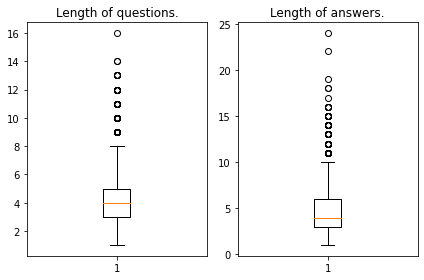

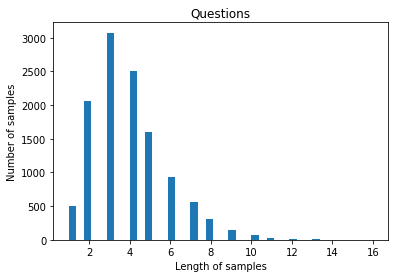

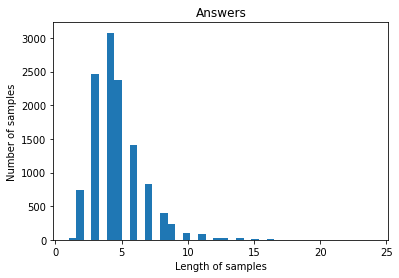

In [704]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axs = axes.ravel()

axs[0].boxplot(q_len)
axs[0].set_title("Length of questions.")

axs[1].boxplot(a_len)
axs[1].set_title("Length of answers.")

fig.tight_layout()

fig2, ax2 = plt.subplots()
ax2.hist(q_len, bins=40)
ax2.set_xlabel("Length of samples")
ax2.set_ylabel("Number of samples")
ax2.set_title("Questions")

fig3, ax3 = plt.subplots()
ax3.hist(a_len, bins=40)
ax3.set_xlabel("Length of samples")
ax3.set_ylabel("Number of samples")
ax3.set_title("Answers")

In [705]:
print(f"95% of q_len is :{np.percentile(q_len, 95)}")
print(f"95% of a_len is :{np.percentile(a_len, 95)}")

95% of q_len is :7.0
95% of a_len is :8.0


데이터셋의 크기가 크지 않으므로 최대길이를 예제와 같이 25으로 정해 모든 단어를 포함하는 방향으로 진행해보겠습니다.

In [706]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt+1
            
    print(f"전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {cnt/len(nested_list):.2%}")

In [707]:
print("Questions\n>>>")
below_threshold_len(25, questions)
print("Answers\n>>>")
below_threshold_len(25, answers)

Questions
>>>
전체 샘플 중 길이가 25 이하인 샘플의 비율: 100.00%
Answers
>>>
전체 샘플 중 길이가 25 이하인 샘플의 비율: 100.00%


In [708]:
MAX_LENGTH = 25
print(MAX_LENGTH)

25


In [709]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [710]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8350
필터링 후의 질문 샘플 개수: 11817
필터링 후의 답변 샘플 개수: 11817


In [711]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [752]:
tf.keras.backend.clear_session()


NUM_LAYERS = 2
D_MODEL = 512
NUM_HEADS = 8
UNITS = 1024
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    8480768     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [753]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

In [754]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [755]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [756]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [757]:
EPOCHS = 50
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[callback])

Epoch 1/50
185/185 [==============================] - 36s 160ms/step - loss: 2.3819 - accuracy: 0.0329
Epoch 2/50
185/185 [==============================] - 29s 159ms/step - loss: 1.7825 - accuracy: 0.0803
Epoch 3/50
185/185 [==============================] - 29s 159ms/step - loss: 1.5807 - accuracy: 0.0845
Epoch 4/50
185/185 [==============================] - 30s 160ms/step - loss: 1.4597 - accuracy: 0.0915
Epoch 5/50
185/185 [==============================] - 29s 158ms/step - loss: 1.3298 - accuracy: 0.0987
Epoch 6/50
185/185 [==============================] - 29s 159ms/step - loss: 1.2034 - accuracy: 0.1090
Epoch 7/50
185/185 [==============================] - 30s 160ms/step - loss: 1.0534 - accuracy: 0.1257
Epoch 8/50
185/185 [==============================] - 29s 158ms/step - loss: 0.8746 - accuracy: 0.1474
Epoch 9/50
185/185 [==============================] - 29s 159ms/step - loss: 0.7124 - accuracy: 0.1723
Epoch 10/50
185/185 [==============================] - 29s 155ms/step - l

In [758]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [759]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])
 
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [760]:
sentence_generation('출근길 너무 힘들어')

입력 : 출근길 너무 힘들어
출력 : 회사 근처로 이사를 가보세요 .


'회사 근처로 이사를 가보세요 .'

In [761]:
sentence_generation('안녕, 넌 이름이 뭐니?')

입력 : 안녕, 넌 이름이 뭐니?
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'

In [762]:
sentence_generation('오늘 날씨는 어때?')

입력 : 오늘 날씨는 어때?
출력 : 사랑에 나이는 중요하지 않다고 생각해요 .


'사랑에 나이는 중요하지 않다고 생각해요 .'

In [763]:
sentence_generation('오늘 날씨는 어때??')

입력 : 오늘 날씨는 어때??
출력 : 사랑에 나이는 중요하지 않다고 생각해요 .


'사랑에 나이는 중요하지 않다고 생각해요 .'

In [764]:
sentence_generation('오늘 날씨는 어떠니?')

입력 : 오늘 날씨는 어떠니?
출력 : 사랑을 말과 행동으로 표현해보세요 .


'사랑을 말과 행동으로 표현해보세요 .'

In [765]:
sentence_generation('오늘 날씨는 어땡?')

입력 : 오늘 날씨는 어땡?
출력 : 친구들과 같이 놀러가세요 .


'친구들과 같이 놀러가세요 .'

In [766]:
sentence_generation('오늘 날씨는 어때ㅋㅋㅋㅋㅋ')

입력 : 오늘 날씨는 어때ㅋㅋㅋㅋㅋ
출력 : 정말 나쁜 생각 하지 마세요 .


'정말 나쁜 생각 하지 마세요 .'

In [767]:
sentence_generation('ㅋ')

입력 : ㅋ
출력 : 항상 사랑했던 걸 수도 있어요 .


'항상 사랑했던 걸 수도 있어요 .'

In [768]:
sentence_generation('ㅋㅋ')

입력 : ㅋㅋ
출력 : 항상 사랑했던 걸 수도 있어요 .


'항상 사랑했던 걸 수도 있어요 .'

In [769]:
sentence_generation('ㅋㅋㅋ')

입력 : ㅋㅋㅋ
출력 : 항상 사랑했던 걸 수도 있어요 .


'항상 사랑했던 걸 수도 있어요 .'

In [770]:
sentence_generation('날씨 좋아?')

입력 : 날씨 좋아?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

In [771]:
sentence_generation('날씨 좋아!')

입력 : 날씨 좋아!
출력 : 하늘을 보고 웃어보세요 .


'하늘을 보고 웃어보세요 .'

## 8. 회고

1. 전처리가 효과가 있었는 지 문장을 생성할 때 문제점이 개선된 것 같아서 좋았다.
2. 하지만 아직 부자연스러운 문장들이 생성될 때가 많고 정확도도 높은 수준이 아니라 더 학습을 오래 시켜야겠다.
3. 추가적으로 KoBERT를 이용한 챗봇만들기를 따라서 구현하면서 PyTorch도 익혀야겠습니다.
[KoBERT-chatbot](https://github.com/nawnoes/WellnessConversation-LanguageModel)
4. Tokenizer로 이전에 사용한 Mecab()등을 사용해 개선되는 지 확인해봐야겠다.